In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as p
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
import copy
%matplotlib inline

In [3]:
data = p.read_table('../data/allBarcodeCounts_noF_doubleBC_OneAncestor.tab')

In [4]:
bc_fasta = SeqIO.to_dict(SeqIO.parse(open('../data/Consecutive_500pool_NoConstant_OneAncestor_ReverseComplement_BothBCs.fasta'),'fasta'))

In [5]:
data['barcode'] = list(bc_fasta.keys()) + ['9999999']
data['barcode'] = [int(bc) for bc in data['barcode'].values]

In [6]:
new_cols = []

for col in data.columns:
    if '/' in col:
        new_cols.append(col.split('/')[1].split('_barcodeCounts')[0])
    else:
        new_cols.append(col)
data.columns = new_cols
data = data.drop(['BCID'],axis=1)

In [7]:
mutation_data = p.read_table('../data/mutationsByBarcodeHighQuality.txt')

In [85]:
mutation_cols = [col for col in mutation_data.columns if ('fitness' not in col and 'error' not in col) ]

tor_genes = ['KOG1','TOR1','SCH9']
ras_genes = ['IRA1','IRA2','GPB1','GPB2','PDE2','RAS2','CYR1','TFS1']

genelist = ['Diploid','Diploid + Chr11Amp','Diploid + Chr12Amp'] + ras_genes + tor_genes

mutation_data = mutation_data[mutation_cols]
mutation_data = mutation_data.sort_values('barcode')

### called neutral by atish's method in ALL 5000 bc experiments (I think - need to verify this)
### [could also be below some set threshold across all experiments]
full_neutral_list = [17615,18486,42040,45014,58284,63611,73731,74185,80465,94896
,120600,125697,132511,134852,135750,190551,228237,238783,255561,298344
,308537,316954,317346,335717,411685,454359,469053] 

### from previous list but never has fitness above 3.5% (per gen) in any of 5000bc experiments
supergood_neutral = [17615, 24362, 42040, 71926, 72939, 73802, 80465, 109476, 113483, 
                     134852, 135750, 238783, 263665, 276406, 316954, 335717, 454359] 

### pulled from supergood list and spiked into 1BigBatch experiments
neutral_spikes = [17615,24362,42040,71926,73802,109476,113483,134852,263665,316954]

# neutrals = full_neutral_list
neutrals = list(np.unique(full_neutral_list+supergood_neutral+neutral_spikes))



In [90]:

spike_in_missense = [9000000 + i for i in range(11)]
spike_in_nonsense = [9000100 + i for i in range(11)]

bc_list = []
gene_list = []
ploidy_list = []
class_list = []
type_list = []
additional_muts = []
for bc in data['barcode'].values:
    if bc in spike_in_missense:
        gene_list.append('IRA1')
        ploidy_list.append('Haploid')
        class_list.append('PKA')
        type_list.append('missense')
        additional_muts.append('None')
    elif bc in spike_in_nonsense:
        gene_list.append('IRA1')
        ploidy_list.append('Haploid')
        class_list.append('PKA')
        type_list.append('stop_gained')
        additional_muts.append('None')
    elif bc == 9999999:
        gene_list.append('Ancestor')
        ploidy_list.append('Haploid')
        class_list.append('Ancestor')
        type_list.append('Ancestor')
        additional_muts.append('None')
    elif bc in mutation_data['barcode'].values:
        
        this_mutant = mutation_data[mutation_data['barcode']==bc]
        found_gene = this_mutant[this_mutant['gene'].isin(genelist)]

        if len(found_gene.index) == 0:
            if bc in neutrals:
                gene_list.append('other')
                type_list.append('other')
                ploidy_list.append('other')
                class_list.append('ExpNeutral')
            else:
                gene_list.append('other')
                type_list.append('other')
                ploidy_list.append('other')
                class_list.append('other')
            

                

        elif len(found_gene.index) == 1:
            gene_list.append(found_gene['gene'].values[0])
            type_list.append(found_gene['type'].values[0])
            ploidy_list.append(found_gene['ploidy'].values[0])

            if found_gene['gene'].values[0] in tor_genes:
                class_list.append('PKA')
            elif found_gene['gene'].values[0] in ras_genes:
                class_list.append('PKA')
            elif found_gene['gene'].values[0] in ['Diploid + Chr11Amp','Diploid + Chr12Amp']:
                class_list.append('Adaptive Diploid')
            elif found_gene['gene'].values[0] in ['Diploid']:
                class_list.append('Diploid')

        else:
            if 'Diploid + Chr11Amp' in found_gene['gene'].values:
                gene_list.append('Diploid + Chr11Amp')
                type_list.append('Diploid + Chr11Amp')
                ploidy_list.append(found_gene['ploidy'].values[0])
                class_list.append('Adaptive Diploid')
                
            elif 'Diploid + Chr12Amp' in found_gene['gene'].values:
                gene_list.append('Diploid + Chr12Amp')
                type_list.append('Diploid + Chr12Amp')
                ploidy_list.append(found_gene['ploidy'].values[0])
                class_list.append('Adaptive Diploid')
            
            elif 'Diploid' in found_gene['gene'].values:
                other_index = np.where(found_gene['gene'].values != 'Diploid')[0][0]
                gene_list.append('Diploid + ' + found_gene['gene'].values[other_index])
                type_list.append(found_gene['type'].values[other_index])
                ploidy_list.append(found_gene['ploidy'].values[0])
                class_list.append('Adaptive Diploid')
            else:
                print('Panic! A double mutant was found!')


        additional = this_mutant[~(this_mutant['gene'].isin(genelist))]
        if len(this_mutant[~(this_mutant['gene'].isin(genelist))]['gene'].values) > 0:
            additional_muts.append('; '.join([str(g)+'-'+str(t) for g,t in zip(additional['gene'].values,additional['type'].values)]))
        else:
            additional_muts.append('None')
        
        
    else:
        
        if bc in neutrals:
            gene_list.append('NotSequenced')
            type_list.append('NotSequenced')
            ploidy_list.append('NotSequenced')
            class_list.append('ExpNeutral')
            additional_muts.append('NotSequenced')
        else:
            gene_list.append('NotSequenced')
            ploidy_list.append('NotSequenced')
            class_list.append('NotSequenced')
            type_list.append('NotSequenced')
            additional_muts.append('NotSequenced')
            

data['gene'] = gene_list
data['type'] = type_list
data['ploidy'] = ploidy_list
data['class'] = class_list

data['additional_muts'] = additional_muts

In [91]:
data[data['class']=='ExpNeutral']

D0-DE1-PCRb  Z4-DE2-PCRa  AA2-DE1-PCRa  13-1-2  18-1-2  C0-DE1-PCRa  \
288          348           28          1309     765     221          183   
350          566           35          1554     341      96          261   
465          278           39          1139     433     131          144   
520          519           54          2108     242      64          286   
521          559           32          1975     229      58          299   
522          397           18          1454     425     150          236   
523          404           31          1518     565     127          198   
524         1378           98          4359     682     201          696   
525          390           24          1043     448     151          192   
526         1159           76          3230     545      93          637   
527         1120           87          3389     488     152          562   
528            4            0             5     324      98            4   
529          854           43          2178     831     243          422   

     G3-DE1-PCRa  20-1-2  21-1-2  23-1-2  \
288           40    2226     298    1577   
350           79    2132     433    1645   
465           32    2369     287    1892   
520           60       0       0       0   
521           64       0       0       0   
522           48       1       0       0   
523           44       0       0       0   
524          153       1       0       0   
525           57       0       1       0   
526          123       0       0       0   
527          162       0       0       0   
528            0       0       0       0   
529           89       0       0       0   

                           ...                          F4-DE1-PCRa  \
288                        ...                                   20   
350                        ...                                   39   
465                        ...                                   24   
520                        ...                                   32   
521                        ...                                   43   
522                        ...                                   25   
523                        ...                                   28   
524                        ...                                   88   
525                        ...                                   22   
526                        ...                                   64   
527                        ...                                   67   
528                        ...                                    1   
529                        ...                                   48   

     P4-DE1-PCRa  Z4-DE1-PCRa  B1-DE2-PCRa  barcode          gene  \
288          293           32          867    72939  NotSequenced   
350          422           32         1176   120600         other   
465          257           33          626   298344         other   
520          358           39         1062    17615  NotSequenced   
521          353           45         1166    24362  NotSequenced   
522          300           28          858    42040  NotSequenced   
523          304           29          964    71926  NotSequenced   
524          775           88         2611    73802  NotSequenced   
525          222           20          787   109476  NotSequenced   
526          777           88         2530   113483  NotSequenced   
527          787           86         2191   134852  NotSequenced   
528            7            0           11   263665  NotSequenced   
529          420           54         1611   316954  NotSequenced   

             type        ploidy       class  \
288  NotSequenced  NotSequenced  ExpNeutral   
350         other         other  ExpNeutral   
465         other         other  ExpNeutral   
520  NotSequenced  NotSequenced  ExpNeutral   
521  NotSequenced  NotSequenced  ExpNeutral   
522  NotSequenced  NotSequenced  ExpNeutral   
523  NotSequenced  NotSequenced 

In [92]:
data.to_csv('../data/BarcodeCounts_noF_DoubleBC_041819_withBCinfo.csv',index=False)

In [93]:
cols_by_condition = np.unique([col.split('-DE')[0] for col in data.columns])

In [94]:
flask_swaps = {'Y1':'CC1','Z1':'DD1','CC1':'Y1','DD1':'Z1'}

merged_data = {}

for merge_col in cols_by_condition:
    this_data = np.zeros(len(data.index))
    for col in data.columns:
#         print(col)
        if 'DE' in col:
            if col.split('-DE')[0] == merge_col:
                this_data = this_data + data[col].values
        elif '-' in col:
            if col == merge_col:
                this_data = this_data + data[col].values
            
            
    merged_data[merge_col] = this_data
merged_data['barcode'] = data['barcode'].values
merged_data['gene'] = data['gene'].values
merged_data['ploidy'] = data['ploidy'].values
merged_data['class'] = data['class'].values
merged_data['type'] = data['type'].values
merged_data['additional_muts'] = data['additional_muts'].values
 
corrected_data = copy.copy(merged_data)
for k,v in flask_swaps.items():
    corrected_data[k] = merged_data[v]
merged_data = p.DataFrame.from_dict(corrected_data)

In [95]:
merged_data

13-0  13-0_pool   13-1-1   13-1-2   13-1-3    13-2-1    13-2-2  \
0       2.0       10.0    512.0    700.0    594.0     594.0     403.0   
1    2625.0     3914.0  43106.0  54385.0  42068.0  160273.0  107883.0   
2      15.0       46.0   2909.0   2977.0   2776.0    2582.0    1640.0   
3     710.0     1187.0  36510.0  32361.0  30864.0   92924.0   59293.0   
4     373.0      631.0  21956.0  23483.0  22294.0   46277.0   33707.0   
5      88.0      165.0   2745.0   4386.0   3120.0    7695.0    7096.0   
6      48.0      104.0   2335.0   3792.0   3057.0    5985.0    5549.0   
7       0.0        3.0     64.0     57.0     65.0      81.0      27.0   
8     170.0      278.0   5462.0   7846.0   6551.0   15647.0   11789.0   
9       6.0        5.0    937.0   1094.0    910.0     936.0     601.0   
10    530.0     1020.0  17086.0  24185.0  16862.0   46192.0   35597.0   
11     60.0       88.0   2692.0   3183.0   2970.0    7467.0    5616.0   
12   2487.0     4607.0  62196.0  82157.0  66626.0  206547.0  148874.0   
13    355.0      663.0  13177.0  17075.0  15191.0   36337.0   26190.0   
14      4.0       10.0    601.0    785.0    745.0     729.0     436.0   
15     86.0      158.0   5419.0   3979.0   4138.0   11600.0    7264.0   
16      4.0       19.0    973.0    971.0    905.0     759.0     467.0   
17      1.0       13.0    483.0    445.0    439.0     344.0     221.0   
18     26.0       34.0   2302.0   2214.0   2286.0    4108.0    2938.0   
19      3.0       15.0    985.0    909.0    868.0    1212.0     744.0   
20     14.0       28.0   1742.0   2231.0   1853.0    2671.0    2260.0   
21     52.0       74.0   3765.0   3849.0   3389.0    7466.0    4876.0   
22     11.0       32.0   1400.0   1741.0   1406.0    2402.0    1814.0   
23      8.0       10.0   1329.0   1473.0   1450.0    1670.0    1202.0   
24    284.0      501.0  17004.0  16808.0  14985.0   38098.0   26081.0   
25      5.0        5.0    622.0    708.0    616.0     660.0     499.0   
26     10.0       21.0   1913.0   2489.0   1846.0    2032.0    1490.0   
27      0.0        0.0      1.0      0.0      0.0       1.0       1.0   
28      6.0       10.0    999.0    986.0    938.0    1119.0     703.0   
29     75.0      108.0   5896.0   7235.0   6890.0   11578.0    9045.0   
..      ...        ...      ...      ...      ...       ...       ...   
520     3.0        3.0    315.0    242.0    266.0     166.0     100.0   
521     1.0        7.0    286.0    229.0    236.0     177.0     123.0   
522     2.0        5.0    478.0    425.0    413.0     311.0     243.0   
523     2.0        5.0    510.0    565.0    504.0     365.0     227.0   
524     2.0       11.0    683.0    682.0    620.0     441.0     344.0   
525     3.0        3.0    416.0    448.0    477.0     306.0     242.0   
526     2.0        7.0    396.0    545.0    413.0     288.0     218.0   
527     3.0        7.0    404.0    488.0    438.0     251.0     217.0   
528     2.0        2.0    337.0    324.0    343.0     178.0     159.0   
529     5.0       12.0    966.0    831.0    829.0     647.0     469.0   
530     0.0        0.0      0.0      0.0      0.0       0.0       0.0   
531     0.0        0.0      0.0      0.0      0.0       0.0       0.0   
532     0.0        0.0      0.0      0.0      0.0       0.0       0.0   
533     0.0        0.0      0.0      0.0      0.0       0.0       0.0   
534     0.0        0.0      0.0      0.0      0.0       0.0       0.0   
535     0.0        0.0      0.0      0.0      0.0       0.0       0.0   
536     0.0        0.0      0.0      0.0      0.0       0.0       0.0   
537     0.0        0.0      0.0      0.0      0.0       0.0       0.0   
538     0.0        0.0      0.0      0.0      0.0       0.0       0.0   
539     0.0        0.0      0.0      0.0      0.0       0.0       0.0   
540     0.0        0.0      0.0      0.0      0.0       0.0       0.0   
541     0.0        0.0      0.0      0.0      0.0       0.0       0.0   
542     0.0        0.0      0.0      0.0      0.0       0.0      

In [96]:
merged_data.to_csv('../data/BarcodeCounts_noF_DoubleBC_merged+flaskswapcorrected_041819_withBCinfo.csv',index=False)

In [97]:
def colnum_string(n):
    string = ""
    if n > 25:
        n = (n % 26)
        return str(chr(65 + n))+str(chr(65 + n))
    else:
        return chr(65 + n)
    

conditions = [colnum_string(i) for i in range(0,33)]

In [10]:
conditions

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'AA',
 'BB',
 'CC',
 'DD',
 'EE',
 'FF',
 'GG']

In [11]:
codenames = {'A':'M3 A',
            'B':'M3 B',
            'C':'M3 C',
            'D':'M3 D',
            'E':'Baffle A',
            'F':'Baffle B'}

['A0', 'A1', 'A2', 'A3', 'A4']
['B0', 'B1', 'B2', 'B3', 'B4']
['C0', 'C1', 'C2', 'C3', 'C4']
['D0', 'D1', 'D2', 'D3', 'D4']
['E0', 'E1', 'E2', 'E3', 'E4']
['F0', 'F1', 'F2', 'F3', 'F4']
['G0', 'G1', 'G2', 'G3', 'G4']
['H0', 'H1', 'H2', 'H3', 'H4']
['I0', 'I1', 'I2', 'I3', 'I4']
['J0', 'J1', 'J2', 'J3', 'J4']
['K0', 'K1', 'K2', 'K3', 'K4']
['L0', 'L1', 'L3', 'L4']
['M0', 'M1', 'M2', 'M3', 'M4']
['N0', 'N1']
['O0', 'O1', 'O2', 'O3', 'O4']
['P0', 'P1', 'P2', 'P3', 'P4']
['Q0', 'Q1', 'Q2', 'Q3', 'Q4']
['R0', 'R1', 'R2', 'R3', 'R4']
['S0', 'S1', 'S2', 'S3', 'S4']
['T0', 'T1', 'T2', 'T3', 'T4']
['U0', 'U1', 'U2', 'U3', 'U4']
['V0', 'V1', 'V2', 'V3', 'V4']
['W0', 'W1', 'W2', 'W3', 'W4']
['X0', 'X2', 'X3', 'X4']
['Y0', 'Y1', 'Y2', 'Y3', 'Y4']
['Z0', 'Z1', 'Z2', 'Z3', 'Z4']
['AA0', 'AA1', 'AA2', 'AA3', 'AA4']
['BB0', 'BB1', 'BB2', 'BB3', 'BB4']
['CC0', 'CC1', 'CC2', 'CC3', 'CC4']
['DD0', 'DD1', 'DD2', 'DD3', 'DD4']
['EE0', 'EE1', 'EE2', 'EE3', 'EE4']
['FF0', 'FF1', 'FF2', 'FF3', 'FF4']
['GG0', 

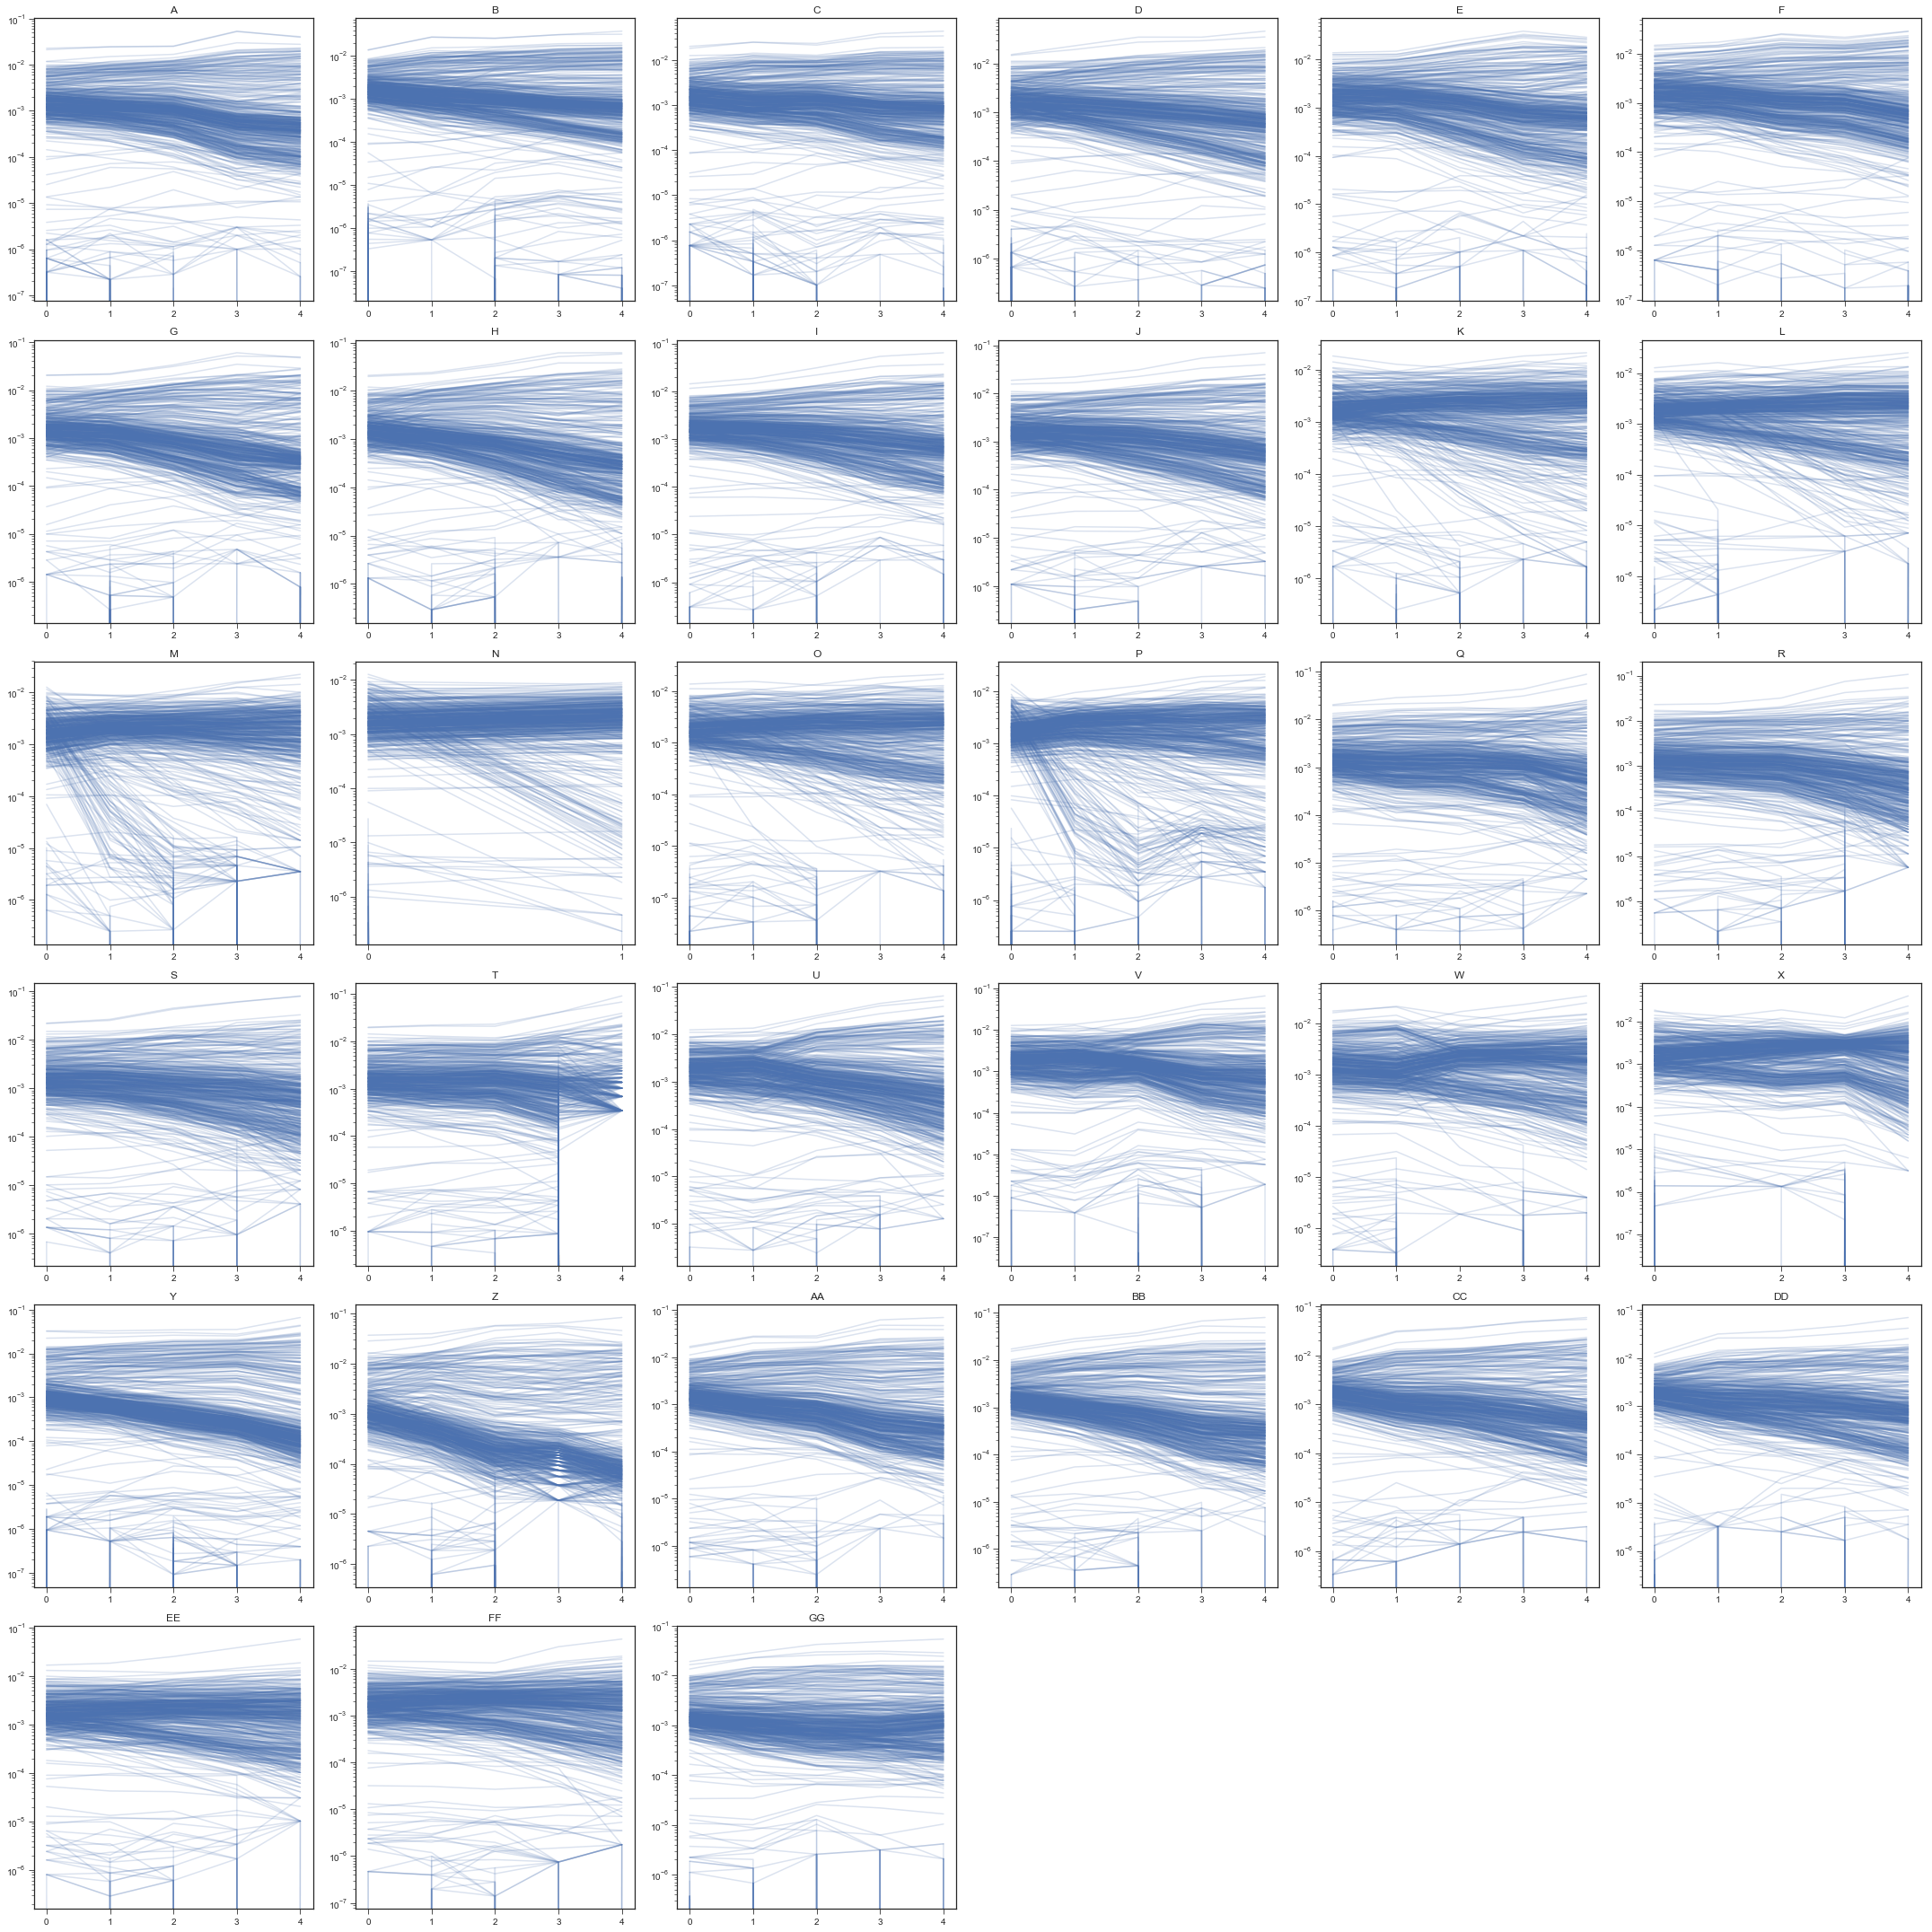

In [174]:
data = merged_data
conditions = [colnum_string(i) for i in range(0,33)]
plt.figure(figsize=(5*6,6*5))
for counter,condition in enumerate(conditions):
    ax = plt.subplot(6,6,counter+1)
    timepoints = []
    these_times = []
    for i in range(5):
        for col in data.columns:
            if condition+str(i) == col:
                if np.nansum(data[col]) > 1000:
                    these_times.append(col)
                    timepoints.append(i)
    print(these_times)
    BC_counts = data[these_times].values
    ax.plot(timepoints,(BC_counts/np.nansum(BC_counts,axis=0)).swapaxes(0,1),alpha=0.2,color='b')
    plt.yscale('log')
#     plt.title(codenames[condition])
    plt.title(condition)
    plt.tight_layout()
    plt.xticks(timepoints,timepoints)
plt.savefig(f'merged_trajectories_swapscorrected.pdf',bbox_inches='tight')

In [81]:
print(np.nansum(data['L2'].values),np.nansum(data['N2'].values),np.nansum(data['N3'].values),np.nansum(data['N4'].values))

11.0 5.0 175.0 1.0


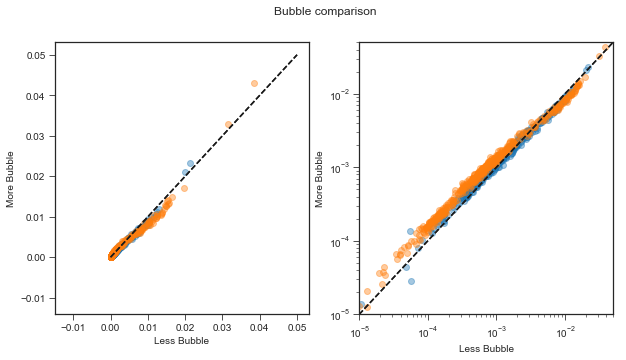

In [177]:
data = no_digest

plt.figure(figsize=(10,5))
plt.suptitle('Bubble comparison')
plt.subplot(1,2,1)
plt.scatter(data['C2-DE3-PCRa'].values/np.nansum(data['C2-DE3-PCRa'].values),data['C2-DE3-PCRb'].values/np.nansum(data['C2-DE3-PCRb'].values),alpha=0.4)
plt.plot([0,0.05],[0,0.05],'k--')

plt.scatter(data['C4-DE3-PCRa'].values/np.nansum(data['C4-DE3-PCRa'].values),data['C4-DE3-PCRb'].values/np.nansum(data['C4-DE3-PCRb'].values),alpha=0.4)
plt.plot([0,0.05],[0,0.05],'k--')
# plt.xlim(0,0.025)
# plt.ylim(0,0.025)
plt.xlabel('Less Bubble')
plt.ylabel('More Bubble')

plt.subplot(1,2,2)
plt.scatter(data['C2-DE3-PCRa'].values/np.nansum(data['C2-DE3-PCRa'].values),data['C2-DE3-PCRb'].values/np.nansum(data['C2-DE3-PCRb'].values),alpha=0.4)
plt.plot([0,0.05],[0,0.05],'k--')

plt.scatter(data['C4-DE3-PCRa'].values/np.nansum(data['C4-DE3-PCRa'].values),data['C4-DE3-PCRb'].values/np.nansum(data['C4-DE3-PCRb'].values),alpha=0.4)
plt.plot([0,0.05],[0,0.05],'k--')

plt.yscale('log')
plt.xscale('log')
plt.xlim(0.00001,0.05)
plt.ylim(0.00001,0.05)
plt.xlabel('Less Bubble')
plt.ylabel('More Bubble')

plt.savefig('bubble_product_comparison_nocutoffs.pdf',bbox_inches='tight')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/scale.py:114: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


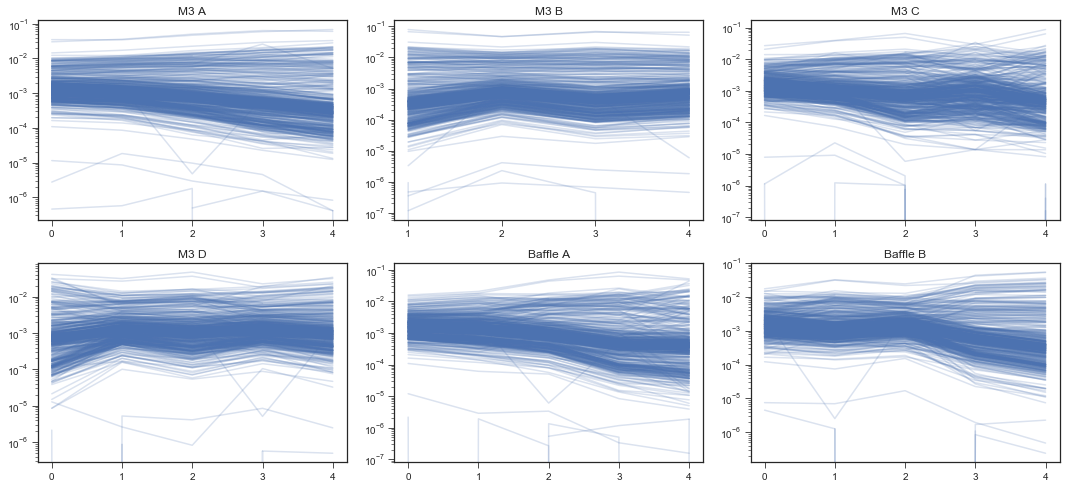

In [70]:
data = my_counts[my_counts['barcode']!=486239]

conditions = ['A','B','C','D','E','F']
plt.figure(figsize=(15,10))
for counter,condition in enumerate(conditions):
    ax = plt.subplot(3,3,counter+1)
    timepoints = []
    these_times = []
    for i in range(5):
        if condition+str(i) in data.columns:
            these_times.append(condition+str(i))
            timepoints.append(i)`
#     timepoints.insert(-1,0)
#     these_times.insert('',0)
    BC_counts = data[these_times].values
    ax.plot(timepoints,(BC_counts/np.nansum(BC_counts,axis=0)).swapaxes(0,1),alpha=0.2,color='b')
    plt.yscale('log')
    plt.title(codenames[condition])
    plt.tight_layout()
    plt.xticks(timepoints,timepoints)
plt.savefig(f'nodigest_noanc_{umi_method}_trajectories.pdf',bbox_inches='tight')

In [72]:
lane3[lane3['barcode']==75841]

barcode    A2    F1    C2   C3    D3    E2    B1    B4
468    75841  6597  3062  4278  154  3465  9015  3922  1690

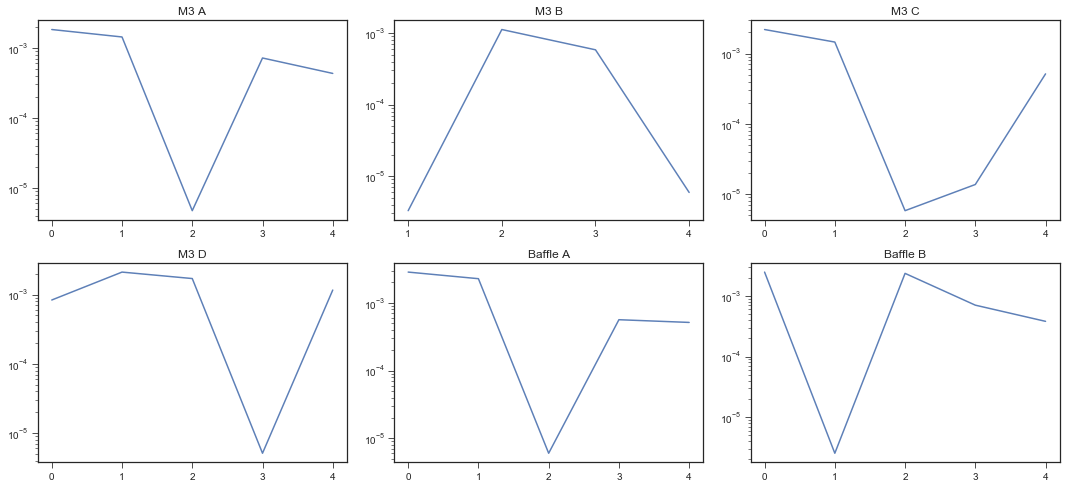

In [61]:
data = my_counts[my_counts['barcode']!=486239]

this_bc = my_counts[my_counts['barcode']==14888]

conditions = ['A','B','C','D','E','F']
plt.figure(figsize=(15,10))
for counter,condition in enumerate(conditions):
    ax = plt.subplot(3,3,counter+1)
    timepoints = []
    these_times = []
    for i in range(5):
        if condition+str(i) in data.columns:
            these_times.append(condition+str(i))
            timepoints.append(i)
#     timepoints.insert(-1,0)
#     these_times.insert('',0)
    BC_counts = data[these_times].values
    ax.plot(timepoints,(this_bc[these_times].values/np.nansum(BC_counts,axis=0)).swapaxes(0,1),alpha=0.9,color='b')
    plt.yscale('log')
    plt.title(codenames[condition])
    plt.tight_layout()
    plt.xticks(timepoints,timepoints)
plt.savefig('14888_{umi_method}_trajectories.pdf',bbox_inches='tight')

In [89]:
## Just a single fitness
my_counts = merged_data
data = my_counts[my_counts['barcode']!=486239]
neutral_spikes = [17615,24362,42040,71926,73802,109476,113483,134852,316954]
# neutral_spikes = [17615,42040,73802,109476,134852]
# neutrals = list(np.unique(neutrals + neutral_spikes))
neutrals = neutral_spikes
print(neutrals)
neutral_locs= []
for bc in neutrals:
    neutral_locs.append(np.where(data['barcode'].values == bc)[0][0])
print(neutral_locs)

# BC_counts = data[['M3_B_0','M3_B_1','M3_B_2','M3_B_3','M3_B_4']].values
BC_counts = data[['C0','C1','C2','C3','C4']].values
BC_counts = data[['A0','A1','A2','A3','A4']].values
timepoints = [0,1,2,3,4]
fitness = 0
kappa = 3.5
coverage = np.nansum(BC_counts,axis=0)

mean_fitness = np.zeros(len(timepoints)-1)
#                                                                         mean_fitness,fitness,BC_counts,timepoints,kappa,coverage
sol = scipy.optimize.minimize(mean_fitness_likelihood_singlefitness,mean_fitness,args=(fitness,BC_counts[neutral_locs,:],timepoints,kappa,coverage),method='BFGS')

[17615, 24362, 42040, 71926, 73802, 109476, 113483, 134852, 316954]
[520, 521, 522, 523, 524, 525, 526, 527, 529]
[[3257. 3805. 3476.  166.  438.]
 [3659. 3743. 3541.  159.  391.]
 [2793. 2617. 2306.   84.  244.]
 [2701. 2799. 2335.  141.  303.]
 [7863. 7757. 6966.  350.  868.]
 [2121. 2111. 2005.  118.  285.]
 [6893. 6444. 5552.  326.  857.]
 [6453. 6567. 5761.  281.  755.]
 [5465. 4792. 4753.  253.  500.]]
[3257.         4707.44274979 7265.43429541 1040.35124998 4085.04537532]
[3659.         5288.46577264 8162.18117498 1168.75812824 4589.24808974]
[2793.         4036.80921098 6230.38317074  892.14032582 3503.0800532 ]
[2701.         3903.83876794 6025.15751671  862.75367707 3387.69037726]
[ 7863.         11364.6368872  17540.10127874  2511.60020836
  9862.05458586]
[2121.         3065.54684443 4731.34361086  677.49002187 2660.23372461]
[ 6893.          9962.66591167 15376.30905689  2201.76271604
  8645.44604608]
[ 6453.          9326.72031452 14394.79505935  2061.21787416
  8093.5823

[2701.         2651.04608272 2497.09656976   63.41116104  352.14176908]
[7863.         7717.5769524  7269.40774826  184.59902232 1025.13540551]
[2121.         2081.7729513  1960.88183061   49.79454742  276.52450656]
[6893.         6765.51671536 6372.63482243  161.82640988  898.67205268]
[6453.         6333.6543398  5965.85122721  151.49656506  841.30723283]
[5465.         5363.92700558 5052.4371543   128.30136805  712.49713737]
[[3257. 3805. 3476.  166.  438.]
 [3659. 3743. 3541.  159.  391.]
 [2793. 2617. 2306.   84.  244.]
 [2701. 2799. 2335.  141.  303.]
 [7863. 7757. 6966.  350.  868.]
 [2121. 2111. 2005.  118.  285.]
 [6893. 6444. 5552.  326.  857.]
 [6453. 6567. 5761.  281.  755.]
 [5465. 4792. 4753.  253.  500.]]
[3257.         3196.76313221 3011.12311282   76.46432859  424.63004143]
[3659.         3591.32830849 3382.77539754   85.90205045  477.04062683]
[2793.         2741.34462028 2582.15132149   65.57103769  364.13623141]
[2701.         2651.04612223 2497.09656976   63.411161

 [5465. 4792. 4753.  253.  500.]]
[3257.         3208.9479127  2897.56680303  149.12911175  366.64197152]
[3659.         3605.01701338 3255.20323373  167.535591    411.89529437]
[2793.         2751.79352784 2484.77251485  127.88382227  314.40928046]
[2701.         2661.15084808 2402.9253715   123.67139418  304.05279861]
[7863.         7746.99337966 6995.26182751  360.0252397   885.14148665]
[2121.         2089.70786701 1886.93251127   97.11478232  238.76193478]
[6893.         6791.30425614 6132.30825092  315.61159573  775.94814543]
[6453.         6357.79578773 5740.86539144  295.46520053  726.41714528]
[5465.         5384.37222687 4861.89824333  250.22738585  615.19753587]
[[3257. 3805. 3476.  166.  438.]
 [3659. 3743. 3541.  159.  391.]
 [2793. 2617. 2306.   84.  244.]
 [2701. 2799. 2335.  141.  303.]
 [7863. 7757. 6966.  350.  868.]
 [2121. 2111. 2005.  118.  285.]
 [6893. 6444. 5552.  326.  857.]
 [6453. 6567. 5761.  281.  755.]
 [5465. 4792. 4753.  253.  500.]]
[3257.         3208.

[6893.         6791.30472308 6132.30867094  315.61158782  775.94837294]
[6453.         6357.79622487 5740.86578465  295.46519312  726.41735828]
[5465.         5384.37259707 4861.89857634  250.22737958  615.19771625]
[[3257. 3805. 3476.  166.  438.]
 [3659. 3743. 3541.  159.  391.]
 [2793. 2617. 2306.   84.  244.]
 [2701. 2799. 2335.  141.  303.]
 [7863. 7757. 6966.  350.  868.]
 [2121. 2111. 2005.  118.  285.]
 [6893. 6444. 5552.  326.  857.]
 [6453. 6567. 5761.  281.  755.]
 [5465. 4792. 4753.  253.  500.]]
[3257.         3208.94813333 2897.56700149  149.12911023  366.64207902]
[3659.         3605.01726124 3255.20345669  167.5355893   411.89541515]
[2793.         2751.79371704 2484.77268503  127.88382097  314.40937264]
[2701.         2661.15103105 2402.92553608  123.67139292  304.05288776]
[7863.         7746.99391231 6995.26230663  360.02523604  885.14174618]
[2121.         2089.70801068 1886.93264051   97.11478133  238.76200479]
[6893.         6791.30472308 6132.30867094  315.611592

[3659.         3605.01726124 3255.20345669  167.5355893   411.89542128]
[2793.         2751.79371704 2484.77268503  127.88382097  314.40937733]
[2701.         2661.15103105 2402.92553608  123.67139292  304.05289229]
[7863.         7746.99391231 6995.26230663  360.02523604  885.14175937]
[2121.         2089.70801068 1886.93264051   97.11478133  238.76200835]
[6893.         6791.30472308 6132.30867094  315.61159252  775.9483845 ]
[6453.         6357.79622487 5740.86578465  295.46519753  726.4173691 ]
[5465.         5384.37259707 4861.89857634  250.22738331  615.19772542]
[[3257. 3805. 3476.  166.  438.]
 [3659. 3743. 3541.  159.  391.]
 [2793. 2617. 2306.   84.  244.]
 [2701. 2799. 2335.  141.  303.]
 [7863. 7757. 6966.  350.  868.]
 [2121. 2111. 2005.  118.  285.]
 [6893. 6444. 5552.  326.  857.]
 [6453. 6567. 5761.  281.  755.]
 [5465. 4792. 4753.  253.  500.]]
[3257.         3208.94808552 2897.56695831  149.12910801  366.64207902]
[3659.         3605.01720752 3255.20340818  167.535586

[3147482. 4549153. 7021131. 1005369. 3947684.]
[ 6294.964  9098.306 14042.262  2010.738  7895.368]


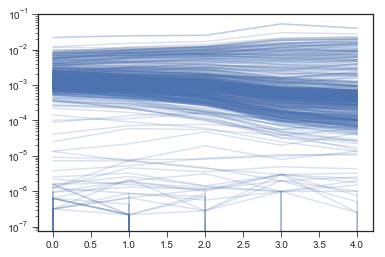

In [90]:
data = merged_data

BC_counts = data[['C0','C1','C2','C3','C4']].values
BC_counts = data[['A0','A1','A2','A3','A4']].values

plt.plot((BC_counts/np.nansum(BC_counts,axis=0)).swapaxes(0,1),alpha=0.2,color='b')
plt.yscale('log')
# plt.title('M3 C with Duplicates Removed ')
print(np.nansum(BC_counts,axis=0))
print(np.nansum(BC_counts,axis=0)/500)
# plt.savefig('m3c_nodups_lineagetraces.pdf',bbox_inches='tight')

In [91]:
lineages = BC_counts.shape[0]
exp_reads = np.nan * np.ones((lineages,len(timepoints)))
# log_likelihoods = np.nan * np.ones((lineages,len(timepoints)))
mean_fitness = sol.x
for i in range(lineages):
    exp_reads[i,:] = expected_reads_singleBC(fitness,BC_counts[i,:],timepoints,mean_fitness,coverage)
#         print(exp_reads)

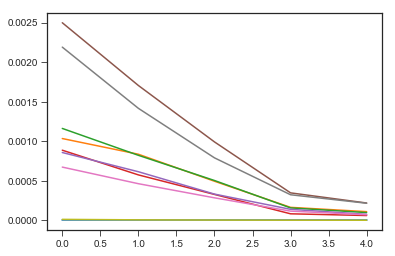

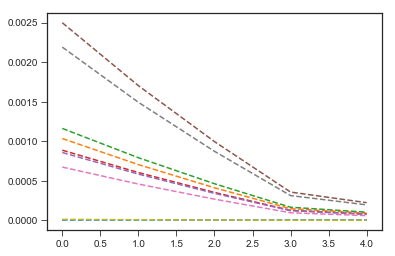

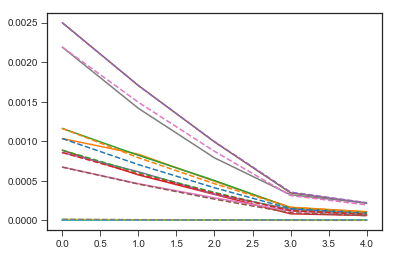

In [92]:
plt.figure()
plt.plot((BC_counts[neutral_locs,:]/np.nansum(BC_counts,axis=0)).swapaxes(0,1))

plt.figure()
plt.plot((exp_reads[neutral_locs,:]/np.nansum(BC_counts,axis=0)).swapaxes(0,1),linestyle='--')

plt.figure()
plt.plot((BC_counts[neutral_locs,:]/np.nansum(BC_counts,axis=0)).swapaxes(0,1))
plt.plot((exp_reads[neutral_locs,:]/np.nansum(BC_counts,axis=0)).swapaxes(0,1),linestyle='--')

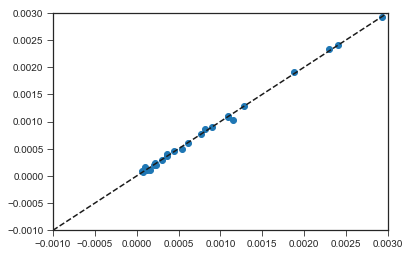

In [64]:
plt.scatter((BC_counts[neutral_locs,:]/np.nansum(BC_counts,axis=0)).swapaxes(0,1),(exp_reads[neutral_locs,:]/np.nansum(BC_counts,axis=0)).swapaxes(0,1))
plt.xlim(-0.001,0.003)
plt.ylim(-0.001,0.003)
plt.plot([-0.001,0.003],[-0.001,0.003],'k--')
# plt.figure()
# plt.scatter((BC_counts[neutral_locs,:]/np.nansum(BC_counts,axis=0)).swapaxes(0,1),(exp_reads[neutral_locs,:]/np.nansum(BC_counts,axis=0)).swapaxes(0,1))
# plt.xlim(-0.001,0.003)
# plt.ylim(-0.001,0.003)
# plt.xscale('log')
# plt.yscale('log')
# plt.plot([-0.001,0.003],[-0.001,0.003],'k--')


In [25]:
np.nansum(BC_counts,axis=0)

array([ 9613763.,   386143., 14721246., 16613548., 40536093.])

In [95]:
def expected_reads_singleBC(fitness,BC_counts,timepoints,mean_fitness,coverage):

    exp_reads = np.zeros(len(timepoints))

    exp_reads[0] = BC_counts[0]

    for t in range(1,len(timepoints)):
        exp_reads[t] = max([coverage[t]/coverage[t-1]*exp_reads[t-1]*np.exp((fitness-mean_fitness[t-1])*(timepoints[t]-timepoints[t-1])),0]) 

    return exp_reads

def mean_fitness_likelihood_jointfitness(parameters,index_mappings,BC_counts,timepoints,kappa,coverage,poisson_cutoff=20,gaussian_cutoff=10):

    """ 
    Likelihood function from Levy et al 2015 (and FitSeq. Fangfei Li et al. 2018)

    If enough expected and actual reads, use full likelihood function derived in Levy supplement, which is:

    P( r_t+1 | r_t ) = Sqrt[ ((r_t*np.exp(-()))]

    If few expected and actual reads, then a Poisson distribution is best fit.

    If few expected but a decent number of actual, then Poisson is well-approximated by Gaussian distribution (and no need to calculate factorial on large value)

    If few expected and no actual reads, then Poisson but observing no instantiations.

    """
    
    mean_fitness = parameters[:len(timepoints)-1]
    fitnesses = [0] + list(parameters[len(timepoints)-1:])
#     print(mean_fitness)
#     print(fitnesses)
#     print(index_mappings)
    
    
    lineages = BC_counts.shape[0]
#     print(lineages)
    exp_reads = np.nan * np.ones((lineages,len(timepoints)))
    log_likelihoods = np.nan * np.ones((lineages,len(timepoints)))
    
    for i in range(lineages):
        
        for group in range(len(index_mappings)):
#             print(index_mappings[group])
            if i in index_mappings[group]:
                fitness = fitnesses[group]

        exp_reads = expected_reads_singleBC(fitness,BC_counts[i,:],timepoints,mean_fitness,coverage)
#         print(exp_reads)

        kappa_mat = kappa * np.ones(BC_counts.shape)

        for tp in range(len(timepoints)):
            if (exp_reads[tp] >= poisson_cutoff) and (BC_counts[i,tp] > 0):

                log_likelihoods[i,tp] = (1/4)*np.log(exp_reads[tp]) - (1/2)*np.log(4*np.pi*kappa) - (3/4)*np.log(BC_counts[i,tp]) - (np.sqrt(exp_reads[tp])-np.sqrt(BC_counts[i,tp]))**2/kappa

            elif (0 < exp_reads[tp] < poisson_cutoff) and (0 < BC_counts[i,tp] < gaussian_cutoff):

                log_likelihoods[i,tp] = BC_counts[i,tp]*np.log(exp_reads[tp]) - exp_reads[tp] - np.log(np.math.factorial(BC_counts[i,tp]))

            elif (0 < exp_reads[tp] < poisson_cutoff) and (BC_counts[i,tp] >= gaussian_cutoff):

                log_likelihoods[i,tp] = BC_counts[i,tp]*np.log(exp_reads[tp]) - exp_reads[tp] - BC_counts[i,tp]*np.log(BC_counts[i,tp]) + BC_counts[i,tp] - (1/2)*np.log(2*np.pi*BC_counts[i,tp])

            elif (0 < exp_reads[tp] < poisson_cutoff) and (BC_counts[i,tp] == 0):

                log_likelihoods[i,tp] = -exp_reads[tp]

    log_likelihood = -np.nansum( log_likelihoods )
    log_likelihood = -np.nansum( log_likelihoods[:,1:] ) # we're using the first timepoint as fixed, so can't reliably include it in the likelihood

    return log_likelihood

In [142]:
## Jointly inferring mean fitness + missense/nonsense fitnesses. Fixing neutrals to zero.

data = merged_data
neutral_spikes = [17615,24362,42040,71926,73802,109476,113483,134852,316954]
# neutral_spikes = [17615,42040,73802,109476,134852]
spike_in_missense = [9000000 + i for i in range(11)]
spike_in_nonsense = [9000100 + i for i in range(11)]
neutrals = neutral_spikes
neutral_locs= []
for bc in neutrals:
    neutral_locs.append(np.where(data['barcode'].values == bc)[0][0])
missense_locs= []
for bc in spike_in_missense:
    if bc in data['barcode'].values:
        missense_locs.append(np.where(data['barcode'].values == bc)[0][0])
nonsense_locs= []
for bc in spike_in_nonsense:
    if bc in data['barcode'].values:
        nonsense_locs.append(np.where(data['barcode'].values == bc)[0][0])

condition = 'AA'
timepoints = [0,1,2,3,4]
BC_counts = data[[condition + str(i) for i in timepoints]].values

# BC_counts = data[['M3_B_0','M3_B_1','M3_B_2','M3_B_3','M3_B_4']].values
# BC_counts = data[['D0','D1','D2','D3','D4']].values
# BC_counts = data[['G0','G1','G2','G3','G4']].values
# BC_counts = data[['H0','H1','H2','H3','H4']].values



kappa = 2.5
coverage = np.nansum(BC_counts,axis=0)

these_counts = BC_counts[[neutral_locs+missense_locs+nonsense_locs],:][0]
index_mappings = [list(range(len(neutral_locs)))]+[list(range(len(neutral_locs),len(neutral_locs)+len(missense_locs)))]+[list(range(len(neutral_locs)+len(missense_locs),len(neutral_locs)+len(missense_locs)+len(nonsense_locs)))]



mean_fitness = np.zeros(len(timepoints)-1)
parameters = [0] * (len(timepoints)-1) + [1.0,0.8]
# parameters = [0,0.5,0.7,1.0] + [1.0,0.8]
#                                                                         mean_fitness,fitness,BC_counts,timepoints,kappa,coverage
sol = scipy.optimize.minimize(mean_fitness_likelihood_jointfitness,parameters,args=(index_mappings,these_counts,timepoints,kappa,coverage),method='BFGS')

In [147]:
np.nansum(BC_counts,axis=0)

array([3384573., 2435971., 4043415.,  426570.,  678054.])

In [143]:
sol.x

array([0.49614159, 0.47393168, 1.1258081 , 0.50736383, 0.5261849 ,
       0.73438862])

In [144]:

these_counts = BC_counts[[neutral_locs+missense_locs+nonsense_locs],:][0]


mean_fitness = sol.x[:len(timepoints)-1]
fitnesses = [0] + list(sol.x[len(timepoints)-1:])
    
lineages = these_counts.shape[0]
# print(lineages)
exp_reads = np.nan * np.ones((lineages,len(timepoints)))
log_likelihoods = np.nan * np.ones((lineages,len(timepoints)))

for i in range(lineages):

    for group in range(len(index_mappings)):
#         print(index_mappings[group])
        if i in index_mappings[group]:
            fitness = fitnesses[group]

    exp_reads[i,:] = expected_reads_singleBC(fitness,these_counts[i,:],timepoints,mean_fitness,coverage)

#         print(exp_reads)

In [145]:
mean_fitness

array([0.49614159, 0.47393168, 1.1258081 , 0.50736383])

Text(0.5,1.02,'AA Mean Fitness Estimate w/ Joint Inference')

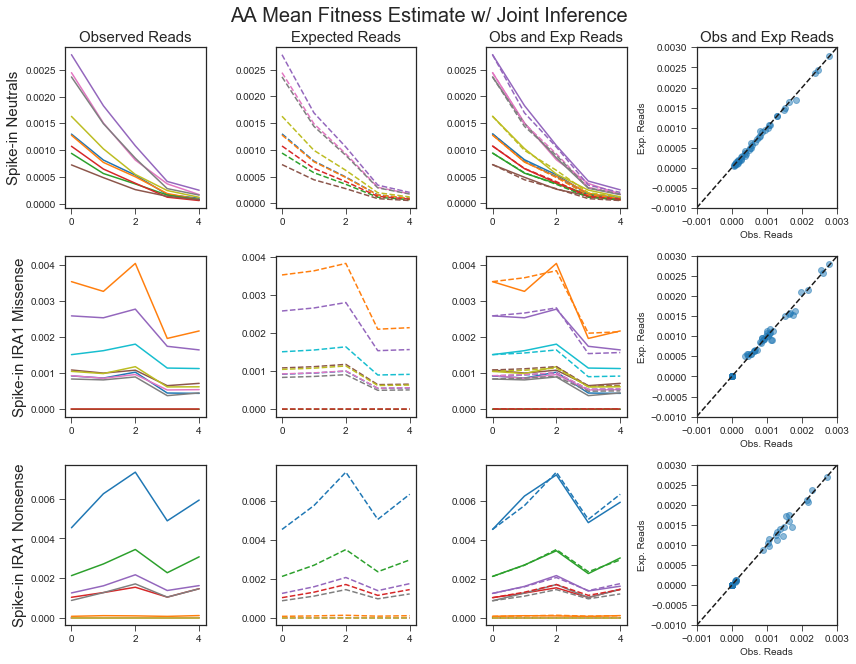

In [146]:
fig = plt.figure(figsize=(12,9))
real_sets = [neutral_locs,missense_locs,nonsense_locs]
set_names = ['Spike-in Neutrals','Spike-in IRA1 Missense','Spike-in IRA1 Nonsense']
exp_sets = index_mappings
subplot_counter = 1
for s in range(len(real_sets)):
    
    plt.subplot(3,4,subplot_counter)
    if s==0:
        plt.title('Observed Reads',fontsize=15)
    plt.ylabel(set_names[s],fontsize=15)
    plt.plot(timepoints,(BC_counts[real_sets[s],:]/np.nansum(BC_counts,axis=0)).swapaxes(0,1))
    subplot_counter += 1
    
    plt.subplot(3,4,subplot_counter)
    if s==0:
        plt.title('Expected Reads',fontsize=15)
    plt.plot(timepoints,(exp_reads[exp_sets[s],:]/np.nansum(BC_counts,axis=0)).swapaxes(0,1),linestyle='--')
    subplot_counter += 1
    
    ax = plt.subplot(3,4,subplot_counter)
    if s==0:
        plt.title('Obs and Exp Reads',fontsize=15)
    plt.plot(timepoints,(BC_counts[real_sets[s],:]/np.nansum(BC_counts,axis=0)).swapaxes(0,1))

    plt.gca().set_prop_cycle(None)
    plt.plot(timepoints,(exp_reads[exp_sets[s],:]/np.nansum(BC_counts,axis=0)).swapaxes(0,1),linestyle='--')
    subplot_counter += 1
    
    plt.subplot(3,4,subplot_counter)
    if s==0:
        plt.title('Obs and Exp Reads',fontsize=15)
    plt.scatter((BC_counts[real_sets[s],:]/np.nansum(BC_counts,axis=0)).swapaxes(0,1),(exp_reads[exp_sets[s],:]/np.nansum(BC_counts,axis=0)).swapaxes(0,1),alpha=0.5)
    subplot_counter += 1
    plt.xlim(-0.001,0.003)
    plt.ylim(-0.001,0.003)
    plt.xlabel('Obs. Reads')
    plt.ylabel('Exp. Reads')
    plt.plot([-0.001,0.003],[-0.001,0.003],'k--')
    
plt.tight_layout()
plt.suptitle(f'{condition} Mean Fitness Estimate w/ Joint Inference',fontsize=20,y=1.02)
# plt.savefig('MeanFitnessEstimation/m3a_meanfitness_est_joint_wANC.pdf',bbox_inches='tight')

# plt.figure(figsize=(9,3))
# subplot_counter = 131
# for s in range(len(real_sets)):
#     plt.subplot(subplot_counter)
#     plt.scatter((BC_counts[real_sets[s],:]/np.nansum(BC_counts,axis=0)).swapaxes(0,1),(exp_reads[exp_sets[s],:]/np.nansum(BC_counts,axis=0)).swapaxes(0,1),alpha=0.5)
#     subplot_counter += 1
#     plt.xlim(-0.001,0.003)
#     plt.ylim(-0.001,0.003)
#     plt.plot([-0.001,0.003],[-0.001,0.003],'k--')
# plt.tight_layout()

In [154]:
fitnesses = p.DataFrame()
fitnesses['barcode'] = data['barcode'].values

neutral_spikes = [17615,24362,42040,71926,73802,109476,113483,134852,316954]
neutrals = neutral_spikes

neutral_locs= []
for bc in neutrals:
    neutral_locs.append(np.where(data['barcode'].values == bc)[0][0])

experiment_details = {}
experiment_details['M3_B'] = ['M3_B_0','M3_B_1','M3_B_2','M3_B_3','M3_B_4']


for experiment in experiment_details.keys():
    fs_fitness, fs_reads, fs_mean = fitseq.fitseq(data[experiment_details[experiment]].values,timepoints,100,infer_ancestor=False,initial_anc_freq=0.9,
                                                  known_neutrals=neutral_locs,max_cycles=25,kappa=2.5,
                                                  mean_fitness_default=mean_fitness)
    fitnesses[experiment+'_fitness_ancinf_setmean'] = fs_fitness[:]

[[1.647700e+04 4.760000e+02 1.222600e+04 7.087000e+03 1.365000e+04]
 [1.839420e+05 1.295400e+04 6.562400e+05 9.624870e+05 3.236861e+06]
 [1.223600e+04 3.160000e+02 7.442000e+03 4.978000e+03 8.902000e+03]
 ...
 [9.476000e+03 4.780000e+02 1.905600e+04 2.657000e+04 6.427700e+04]
 [4.222000e+03 2.150000e+02 1.021200e+04 1.426000e+04 3.201200e+04]
 [2.623000e+04 1.222000e+03 6.111600e+04 7.446400e+04 1.977630e+05]]
[-3.29582972e-01  5.61504052e-01 -4.41675569e-01  4.93637313e-01
             nan -6.03315391e-01  5.42029554e-01             nan
 -4.36111464e-01  6.13981457e-01 -4.19745028e-01 -4.15590260e-03
  7.22468352e-01  6.24980584e-01 -4.45281191e-01  5.15476830e-01
 -4.57352414e-01 -2.32655558e-01  3.00695987e-01 -1.56271916e-01
 -4.34851165e-01  2.60836186e-01 -1.04624472e-01 -6.75651181e-02
  2.85553174e-01 -7.87219507e-01 -2.89999197e-01  6.66730770e-01
 -3.77519056e-01             nan -2.65529504e-01  2.71299408e-01
  8.30135897e-02 -3.87578038e-01 -3.31561580e-01  3.56345407e-01
 

[0.0, 54499.88871051033]


In [143]:
mean_fitness

array([0.6500031 , 0.66337639, 0.79419227, 0.84253195])

In [155]:
fitnesses
# data[experiment_details[experiment]].values

barcode  M3_B_fitness_ancinf_setmean
0         53                     0.157806
1        151                     1.048893
2        262                     0.045713
3        273                     0.981026
4        323                          NaN
5        323                    -0.115927
6        415                     1.029418
7        499                          NaN
8        622                     0.051277
9        689                     1.101370
10       697                     0.067644
11      1185                     0.483233
12      1379                     1.209857
13      1488                     1.112369
14      1564                     0.042108
15      1617                     1.002866
16      1641                     0.030036
17      1683                     0.254733
18      1866                     0.788085
19      2037                     0.331117
20      2039                     0.052538
21      2288                     0.748225
22      2468                     0.382764
23      2608                     0.419824
24      2768                     0.772942
25      2776                    -0.299831
26      2808                     0.197390
27      3160                     1.154120
28      3250                     0.109870
29      3298                          NaN
..       ...                          ...
476   375115                    -0.571776
477   378857                     0.058021
478   379777                     0.553690
479   381707                     0.201918
480   392361                    -0.291326
481   411793                     1.137159
482   414373                          NaN
483   419648                    -0.090452
484   419831                     0.054390
485   425471                    -0.001069
486   430247                    -0.307404
487   434397                     0.008721
488   454851                    -0.004721
489  9000001                     0.309749
490  9000002                     0.295033
491  9000003                     0.602166
492  9000005                     0.600997
493  9000006                     0.468527
494  9000007                     0.589399
495  9000008                     0.357835
496  9000009                     0.417352
497  9000010                     0.750284
498  9000101                     0.562536
499  9000103                     0.666564
500  9000104                     0.686222
501  9000105                     0.698228
502  9000106                     0.639390
503  9000107                     0.715202
504  9000109                     0.724683
505  9000110                     0.635694

[506 rows x 2 columns]

In [151]:
from Bio import SeqIO

In [154]:
oneanc = p.read_table('allBarcodeCounts_oneancestor.tab')

front_fasta = SeqIO.parse(open('Consecutive_500pool_NoConstant_OneAncestor_ReverseComplement.fasta'),'fasta')


# oneanc = p.read_table('.tab')
oneanc.columns = ['BCID'] + [col.split('/')[1].split('_barcodeCounts')[0] for col in oneanc.columns if '/' in col]

barcode_list = []
for record in front_fasta:
#     print(record)
    barcode_list.append(record.id)
oneanc['barcode'] = barcode_list

In [155]:
oneanc.to_csv('')

BCID  FF3-DE1-PCRa  21-0-2  B1-DE1-PCRa  B2-DE1-PCRb  J1-DE1-PCRa  \
0       1          3424       0          493          224         4945   
1       2         39418      12        12373        13842        68359   
2       3          2640       0          326          172         3661   
3       4         12330       3         5290         4052        30824   
4       5          4752       3         1959         1363        17183   
5       6          4876       3         4852         4586        23659   
6       7             0       0            0            0            0   
7       8          2124       0          303          135         3667   
8       9          3086       3         1410         1476         7893   
9      10          2162       2          389          154         4379   
10     11             0       0            0            2            1   
11     12             0       0            0            0            1   
12     13         17576      12        13917        12704        51827   
13     14          5717       5         4074         3885        19174   
14     15          1866       1          306          163         3424   
15     16         10075       2         4066         2630        24755   
16     17           438       1          167           67         1741   
17     18           642       2          371          105         2958   
18     19          2897       2         1768         1293        12420   
19     20          6343       0          930          422         8200   
20     21           537       0          259          157         2594   
21     22          5155       5         1727         1077        14049   
22     23          1349       0          911          792         9151   
23     24          2318       1          918          515         9789   
24     25          7848       2         3152         1955        19609   
25     26           984       2          178           96         2911   
26     27          3955       1          598          344         7993   
27     28            10       0            6            5           53   
28     29          2866       1          441          229         4826   
29     30             0       0            1            0            0   
..    ...           ...     ...          ...          ...          ...   
519   520             0       0            0            0            0   
520   521           521       0          318          104         2938   
521   522           508       0          244           83         2779   
522   523           361       0          239           76         1895   
523   524           369       0          186           58         2380   
524   525          1311       0          557          183         5742   
525   526           371       0          184           63         1553   
526   527          1054       0          509          189         5118   
527   528          1145       0          588          159         5199   
528   529             1       0            2            2           27   
529   530           805       0          360          105         3187   
530   531           270       0          203          173         3017   
531   532           552       0          584          452         6769   
532   533             0       0            0            0            1   
533   534          1492       0          837          583         8515   
534   535           514       0          289          169         3423   
535   536           475       0          273          189         3138   
536   537           360       0          221          127         2744   
537   538           397       0          251          197         3230   
538   539           943       0          500          308         5091   
539   540           999       0         1174         1023        11516   
540   541            41       0           27           21          226   
541   542

In [54]:

data = merged_data

neutral_spikes = [17615,24362,42040,71926,73802,109476,113483,134852,263665,316954]
diploids = 
# neutrals = list(np.unique(neutrals + neutral_spikes))
neutrals = neutral_spikes
neutrals = diploids
# print(neutrals)

fitnesses = {}
for experiment in conditions:
#     l = range(len(experiment_details[experiment]))
#     print(np.sum(data[experiment_details[experiment]].values))
    condition = experiment
    cov_thresh = 0
    these_times = []
    timepoints = []
    for i in range(5):
        if condition+str(i) in data.columns:
            these_times.append(condition+str(i))
            timepoints.append(i)
    answer = atish.inferFitness(data['barcode'].values,timepoints,{'rep1':data[these_times].values},neutralBarcodes=neutrals,lowCoverageThresh=cov_thresh,use_all_neutral=True)
#     answer = atish.inferFitness(data['barcode'].values,timepoints,{'rep1':data[experiment_details[experiment]].values},lowCoverageThresh=cov_thresh,neutralBarcodes=neutral_spikes)
    print(answer['rep1']['neutralBarcodes'])
#     neutrals.append(answer['rep1']['neutralBarcodes'])
    fitnesses[experiment+'_fitness'] = answer['rep1']['aveFitness']
    fitnesses[experiment+'_error'] = answer['rep1']['aveError']
fitnesses['barcode'] = data['barcode'].values

[17615, 24362, 42040, 71926, 73802, 109476, 113483, 134852, 263665, 316954]
[0, 1, 2, 3, 4]
neutrals inside 551
5
reads 41247.0 40668.0
reads 40668.0 36726.0
reads 36726.0 1881.0
reads 1881.0 4650.0
reads 41247.0 40668.0
reads 40668.0 36726.0
reads 36726.0 1881.0
reads 1881.0 4650.0
inside again 551
inside again2 [0.38247513 0.53593985 1.02811172 0.46271077]
Multiplicative noise consistency checks

rep1  inconsistent times:

No clear inconsistencies

[ 17615  24362  42040  71926  73802 109476 113483 134852 263665 316954]
[0, 1, 2, 3, 4]
neutrals inside 551
5
reads 136584.0 16757.0
reads 16757.0 75228.0
reads 75228.0 34455.0
reads 34455.0 41830.0
reads 136584.0 16757.0
reads 16757.0 75228.0
reads 75228.0 34455.0
reads 34455.0 41830.0
inside again 551
inside again2 [0.52010962 0.56425115 0.56850439 0.53843464]
Multiplicative noise consistency checks

rep1  inconsistent times:

No clear inconsistencies

[ 17615  24362  42040  71926  73802 109476 113483 134852 263665 316954]
[0, 1, 2, 3, 4

/Users/grantkinsler/Documents/Stanford/Research/StarryNight/Git/starry-night/FitnessAssay/fitness-assay-python-master-update/fitness_assay_grantedits.py:214: RuntimeWarning: divide by zero encountered in power
  zScores = zScores*np.power(expectedReads,-0.5)
/Users/grantkinsler/Documents/Stanford/Research/StarryNight/Git/starry-night/FitnessAssay/fitness-assay-python-master-update/fitness_assay_grantedits.py:214: RuntimeWarning: invalid value encountered in multiply
  zScores = zScores*np.power(expectedReads,-0.5)
/Users/grantkinsler/Documents/Stanford/Research/StarryNight/Git/starry-night/FitnessAssay/fitness-assay-python-master-update/fitness_assay_grantedits.py:379: RuntimeWarning: divide by zero encountered in log
  allTimeFitness = np.log(allReads[repName][:,1:]/totReads[1:])-np.log(allReads[repName][:,0:-1]/totReads[0:-1])
/Users/grantkinsler/Documents/Stanford/Research/StarryNight/Git/starry-night/FitnessAssay/fitness-assay-python-master-update/fitness_assay_grantedits.py:379: R


neutrals inside 551
5
reads 52136.0 62569.0
reads 62569.0 28127.0
reads 28127.0 4480.0
reads 4480.0 4420.0
reads 52136.0 62569.0
reads 62569.0 28127.0
reads 28127.0 4480.0
reads 4480.0 4420.0
inside again 551
inside again2 [-0.17187238  0.17708027  0.07346587  0.4684199 ]
Multiplicative noise consistency checks

rep1  inconsistent times:

No clear inconsistencies

[ 17615  24362  42040  71926  73802 109476 113483 134852 263665 316954]
[0, 1, 2, 3, 4]
neutrals inside 551
5
reads 35916.0 17608.0
reads 17608.0 16009.0
reads 16009.0 8010.0
reads 8010.0 658.0
reads 35916.0 17608.0
reads 17608.0 16009.0
reads 16009.0 8010.0
reads 8010.0 658.0
inside again 551
inside again2 [0.69801849 0.17948742 0.54912943 0.82289139]
Multiplicative noise consistency checks

rep1  inconsistent times:

No clear inconsistencies

[ 17615  24362  42040  71926  73802 109476 113483 134852 263665 316954]
[0, 1, 2, 3, 4]
neutrals inside 551
5
reads 17933.0 34980.0
reads 34980.0 16501.0
reads 16501.0 1511.0
reads 15

In [55]:
fitness_df = p.DataFrame(fitnesses)

In [ ]:
spike_in_missense = [9000000 + i for i in range(11)]
spike_in_nonsense = [9000100 + i for i in range(11)]

color_set = []
alphas = []
for bc in data['barcode'].values:
    if bc in spike_in_missense:
        color_set.append(colors.to_rgba('r',0.5))
    elif bc in spike_in_nonsense:
        color_set.append(colors.to_rgba('orange',0.5))
    elif bc in neutrals:
        colors.append(colors.to_rgba('b',0.5))
    else:
        colors.append(colors.to_rgba('k',0.1))

for j,condition in enumerate(['A','B','C','D']):
    plt.scatter([jitter_point(j,0.05) for  i in range(len(fitnesses[f'{condition}_fitness']))],fitnesses[f'{condition}_fitness'],alpha=0.2,color=color_set)
    
    
# plt.savefig('fitness.png',bbox_inches='tight')

In [27]:
[jitter_point(0,2.0)]*len(fitnesses['A_fitness'])

[-4.330872384691713,
 -4.330872384691713,
 -4.330872384691713,
 -4.330872384691713,
 -4.330872384691713,
 -4.330872384691713,
 -4.330872384691713,
 -4.330872384691713,
 -4.330872384691713,
 -4.330872384691713,
 -4.330872384691713,
 -4.330872384691713,
 -4.330872384691713,
 -4.330872384691713,
 -4.330872384691713,
 -4.330872384691713,
 -4.330872384691713,
 -4.330872384691713,
 -4.330872384691713,
 -4.330872384691713,
 -4.330872384691713,
 -4.330872384691713,
 -4.330872384691713,
 -4.330872384691713,
 -4.330872384691713,
 -4.330872384691713,
 -4.330872384691713,
 -4.330872384691713,
 -4.330872384691713,
 -4.330872384691713,
 -4.330872384691713,
 -4.330872384691713,
 -4.330872384691713,
 -4.330872384691713,
 -4.330872384691713,
 -4.330872384691713,
 -4.330872384691713,
 -4.330872384691713,
 -4.330872384691713,
 -4.330872384691713,
 -4.330872384691713,
 -4.330872384691713,
 -4.330872384691713,
 -4.330872384691713,
 -4.330872384691713,
 -4.330872384691713,
 -4.330872384691713,
 -4.330872384